In [27]:
#!wget https://pjreddie.com/media/files/yolov3.weights && mv yolov3.weights cfg/
#!wget https://github.com/ayooshkathuria/pytorch-yolo-v3/blob/master/data/coco.names
#!wget https://raw.githubusercontent.com/ayooshkathuria/pytorch-yolo-v3/master/cfg/yolov3.cfg
!wget https://pjreddie.com/media/files/tiny.weights && mv tiny.weights cfg/
!wget https://raw.githubusercontent.com/ultralytics/yolov3/master/cfg/yolov3-tiny.cfg && mv yolov3-tiny.cfg cfg/

--2019-02-21 19:01:50--  https://pjreddie.com/media/files/tiny.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.3.39
Connecting to pjreddie.com (pjreddie.com)|128.208.3.39|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4185968 (4.0M) [application/octet-stream]
Saving to: ‘tiny.weights’

tiny.weights        100%[===================>]   3.99M  5.16MB/s    in 0.8s    

2019-02-21 19:01:51 (5.16 MB/s) - ‘tiny.weights’ saved [4185968/4185968]

--2019-02-21 19:01:51--  https://raw.githubusercontent.com/ultralytics/yolov3/master/cfg/yolov3-tiny.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.248.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.248.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1915 (1.9K) [text/plain]
Saving to: ‘yolov3-tiny.cfg’

yolov3-tiny.cfg     100%[===================>]   1.87K  --.-KB/s    in 0s      

2019-02-21 19:01:52 (414 MB/s) - ‘yolov3

In [32]:
ls cfg/

coco.names    tiny-yolo-voc.cfg  yolov3-tiny.cfg
tiny.weights  yolov3.cfg         yolov3.weights


In [19]:
#!pip install torch torchvision
#!pip install opencv-python
#mv yolov3.cfg cfg/
#mv coco.names cfg/

In [16]:
from __future__ import division
import time
import torch 
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import cv2 
from util import *
import argparse
import os 
import os.path as osp
from darknet import Darknet
from preprocess import prep_image, inp_to_image
import pandas as pd
import random 
import pickle as pkl
import itertools

In [2]:
RESOLUTION = 480

In [3]:
def get_test_input(input_dim, CUDA):
    img = cv2.imread("dog-cycle-car.png")
    img = cv2.resize(img, (input_dim, input_dim)) 
    img_ =  img[:,:,::-1].transpose((2,0,1))
    img_ = img_[np.newaxis,:,:,:]/255.0
    img_ = torch.from_numpy(img_).float()
    img_ = Variable(img_)
    
    if CUDA:
        img_ = img_.cuda()
    num_classes
    return img_


In [17]:
class YoloImage():
    def __init__(self, path, resolution=160,  use_cuda=True):
        self.use_cuda = use_cuda
        assert resolution%32 == 0, "Resolution must be multiple of 32"
        self.resolution = resolution
        self.img, self.orig_im, self.dim = prep_image(path, self.resolution)
        self.im_dim = torch.FloatTensor(self.dim).repeat(1,2) 
        if self.use_cuda:
            self.img = self.img.cuda()
            
        self.predictions = None
        
    def plot(path):
        return plt.imshow(self.orig_im)
    
    
    def prepare_to_predict(self):
        return Variable(self.img)

    def write(self, prediction):
        c1 = tuple(prediction[1:3].int().cpu().numpy())
        c2 = tuple(prediction[3:5].int().cpu().numpy())
        detected_class = int(prediction[-1])
        label = "{0}".format(yv3.classes[detected_class])
        color = random.choice(yv3.colors)
        print(label, color)
        cv2.rectangle(self.img, c1, c2, color, 1)
        t_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_PLAIN, 1 , 1)[0]
        c2 = c1[0] + t_size[0] + 3, c1[1] + t_size[1] + 4
        cv2.rectangle(self.img, c1, c2,color, -1)
        cv2.putText(self.img, label, (c1[0], c1[1] + t_size[1] + 4), cv2.FONT_HERSHEY_PLAIN, 1, [225,255,255], 1)
        return img


In [28]:
class YoloV3:
    def __init__(self, use_cuda_if_available=True, num_classes=79, resolution=160, confidence=0.5, nms_thresh=0.4):
        
        assert resolution%32 == 0, "Resolution must be multiple of 32"
        
        self.use_cuda = torch.cuda.is_available() if use_cuda_if_available else False
        self.num_classes = num_classes
        self.resolution = resolution
        self.classes = load_classes('cfg/coco.names') 
        self.model = Darknet("cfg/yolov3-tiny.cfg") 
        self.colors = pkl.load(open("pallete", "rb"))
        self.confidence = confidence
        self.nms_thresh = nms_thresh
        self.init_model()
            
    def init_model(self):
        self.model.load_weights("cfg/yol")
        self.model.net_info["height"] = self.resolution
        self.inp_dim = int(self.model.net_info["height"])

        if self.use_cuda:
            self.model.cuda()
    
    def predict_(self, image: YoloImage):
        with torch.no_grad():
            prediction = self.model(image.prepare_to_predict(), self.use_cuda)
        output = write_results(prediction, self.confidence, self.num_classes, nms = True, nms_conf = self.nms_thresh)
        torch.cuda.synchronize()
        objs = [self.classes[int(x[-1])] for x in output if int(x[0]) == 0]
        print("{0:20s} {1:s}".format("Objects Detected:", " ".join(objs)))
        print("----------------------------------------------------------")
        rescaled_output = self.rescale_image(image.im_dim, output)
        torch.cuda.synchronize()
        
        print(self.clean_predicted_labels(rescaled_output))

        return rescaled_output
            
    def predict_from_path(self, path):
        image = YoloImage(path=path,
                          resolution=self.resolution,
                          use_cuda=self.use_cuda)
        return self.predict_(image)
    
    def clean_predicted_labels(self, output):
        return [
             { yv3.classes[int(x[-1])]:{
                 "box1":tuple(x[1:3].int().cpu().numpy()),
                 "box2":tuple(x[1:3].int().cpu().numpy()),
                 "color":random.choice(self.colors)
             }} for x in output]
        
    
    def rescale_image(self, im_dim_list, output):
        im_dim_list = torch.index_select(im_dim_list.cuda(), 0, output[:,0].long())

        scaling_factor = torch.min(self.inp_dim/im_dim_list,1)[0].view(-1,1)

        output[:,[1,3]] -= (self.inp_dim - scaling_factor*im_dim_list[:,0].view(-1,1))/2
        output[:,[2,4]] -= (self.inp_dim - scaling_factor*im_dim_list[:,1].view(-1,1))/2

        output[:,1:5] /= scaling_factor

        for i in range(output.shape[0]):
            output[i, [1,3]] = torch.clamp(output[i, [1,3]], 0.0, im_dim_list[i,0])
            output[i, [2,4]] = torch.clamp(output[i, [2,4]], 0.0, im_dim_list[i,1])
            
        return output
    

yv3 = YoloV3(resolution=RESOLUTION)

FileNotFoundError: [Errno 2] No such file or directory: 'cfg/tiny.weightsin'

In [8]:
ls

bbox.py       logger.py                   Models.ipynb   YOLO.ipynb
cfg/          logs/                       pallete        yolov3.onnx
darknet.py    model.pt                    preprocess.py
data/         models/                     __pycache__/
Export.ipynb  Models Augmentation .ipynb  util.py


In [7]:
# Input to the model
x = torch.randn(1, 3, 480, 480, requires_grad=True).cuda()

# Export the model
torch_out = torch.onnx._export(yv3.model,             # model being run
                               x,                       # model input (or a tuple for multiple inputs)
                               "yolov3.onnx", # where to save the model (can be a file or file-like object)
                               export_params=True)      # store the trained parameter weights inside the model file

/home/ubuntu/image-exploration/util.py:42: TracerWarning: There are 3 live references to the data region being modified when tracing in-place operator copy_ (possibly due to an assignment). This might cause the trace to be incorrect, because all other views that also reference this data will not not reflect this change in the trace! On the other hand, if all other views use the same memory chunk, but are disjoint (e.g. are outputs of torch.split), this might still be safe.
  prediction[:,:,0] = torch.sigmoid(prediction[:,:,0])
/home/ubuntu/image-exploration/util.py:43: TracerWarning: There are 3 live references to the data region being modified when tracing in-place operator copy_ (possibly due to an assignment). This might cause the trace to be incorrect, because all other views that also reference this data will not not reflect this change in the trace! On the other hand, if all other views use the same memory chunk, but are disjoint (e.g. are outputs of torch.split), this might stil

In [8]:
ls 

bbox.py     Export.ipynb  models/                     preprocess.py
cfg/        logger.py     Models Augmentation .ipynb  __pycache__/
darknet.py  logs/         Models.ipynb                util.py
data/       model.pt      pallete                     YOLO.ipynb


In [11]:
yi.prepare_to_predict().shape

torch.Size([1, 3, 480, 480])

In [12]:
yv3.model(yi.prepare_to_predict())

/home/ubuntu/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


tensor([[[1.7715e+01, 9.0591e+00, 8.5985e+01,  ..., 9.2461e-05,
          7.6157e-05, 4.7876e-05],
         [2.0536e+01, 1.4030e+01, 9.0592e+01,  ..., 5.3807e-06,
          6.5323e-05, 1.0885e-04],
         [2.1338e+01, 8.8745e+00, 4.4488e+02,  ..., 1.6721e-04,
          8.5842e-04, 5.4856e-04],
         ...,
         [4.7616e+02, 4.7545e+02, 4.0016e+00,  ..., 3.4156e-06,
          1.4472e-05, 8.2060e-06],
         [4.7513e+02, 4.7442e+02, 9.1216e+00,  ..., 2.0185e-05,
          8.7396e-05, 7.7026e-05],
         [4.7523e+02, 4.7687e+02, 4.5179e+01,  ..., 7.2201e-06,
          3.7787e-05, 5.2157e-05]]], device='cuda:0')

In [11]:
%%time 
PATH = "data/parsed/train/bed_room/000097f79318fcea2da6e1e713865316c18fae0f.webp"
yi = YoloImage(path=PATH, resolution=RESOLUTION)

CPU times: user 8 ms, sys: 4 ms, total: 12 ms
Wall time: 6.63 ms


wine glass (16, 179, 33)
wine glass (13, 39, 73)
chair (53, 34, 86)
chair (82, 144, 81)
chair (156, 100, 106)
chair (39, 129, 113)
chair (22, 18, 5)
pottedplant (52, 11, 76)


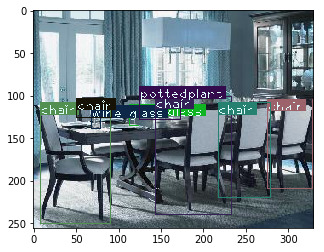

In [52]:
def write(x, img):
    c1 = tuple(x[1:3].int().cpu().numpy())
    c2 = tuple(x[3:5].int().cpu().numpy())

    detected_class = int(x[-1])
    label = "{0}".format(yv3.classes[detected_class])
    color = random.choice(yv3.colors)
    print(label, color)
    cv2.rectangle(img, c1, c2, color, 1)
    t_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_PLAIN, 1 , 1)[0]
    c2 = c1[0] + t_size[0] + 3, c1[1] + t_size[1] + 4
    cv2.rectangle(img, c1, c2,color, -1)
    cv2.putText(img, label, (c1[0], c1[1] + t_size[1] + 4), cv2.FONT_HERSHEY_PLAIN, 1, [225,255,255], 1)
    return img

for pred in preds:
    plt.imshow(write(pred, yi.orig_im))
